In [1]:
import tqdm, torch, json, pickle, os, gc, time, sys
sys.path.append('../')
import pandas as pd
import numpy as np
from collections import OrderedDict
from src.utils.dataset import FPolyDatasetV2, collate_fn
from src.utils.data import CrossValidation
from src.utils.visualization import plot_scatter
from torch_geometric.nn import global_add_pool, global_max_pool, global_mean_pool
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import seaborn as sns
from pathlib import Path
from sklearn.svm import SVR

# XGBoost and SVR 

/home/jhyang/anaconda3/envs/poly/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


 - objective functions

In [2]:
def xgb_obj_fnc(eta, max_depth):
    global train_data, valid_data, test_data, m_best, best
    params = {
        'max_depth':int(np.round(max_depth)),
        'min_child_weight': 1,
        'eta':eta,
        # Other parameters
        'objective':'reg:squarederror',
        'eval_metric':'mae'
    }
    booster = xgb.train(params, dtrain=train_data, num_boost_round=50, early_stopping_rounds=5, 
                        evals=[(valid_data, 'valid')], verbose_eval=False)
    y_train = train_data.get_label()
    y_valid = valid_data.get_label()
    p_train = booster.predict(train_data, iteration_range=(0, booster.best_iteration+1))
    p_valid = booster.predict(valid_data, iteration_range=(0, booster.best_iteration+1))
    train_r2, train_mae = r2_score(y_train, p_train), mean_absolute_error(y_train, p_train)
    valid_r2, valid_mae = r2_score(y_valid, p_valid), mean_absolute_error(y_valid, p_valid)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        m_best = m
        y_test = test_data.get_label()
        p_test = booster.predict(test_data, iteration_range=(0, booster.best_iteration+1))
        test_r2, test_mae = r2_score(test_tgt, p_test), mean_absolute_error(test_tgt, p_test)        
        best = {'params':params, 'train':[y_train, p_train], 'valid':[y_valid, p_valid], 'test':[y_test, p_test],
                'measure':[train_r2, train_mae, valid_r2, valid_mae, test_r2, test_mae]}
    return m

def svr_obj_fnc1(c, eps):
    global x_train, x_valid, y_train, y_valid, test_feat, test_tgt, kernel, m_best, best
    params = {'kernel':kernel, 'C':c, 'epsilon':eps}
    svr = SVR(**params)
    svr.fit(x_train, y_train.reshape(-1))
    p_train = svr.predict(x_train)
    p_valid = svr.predict(x_valid)
    train_r2, train_mae = r2_score(y_train, p_train), mean_absolute_error(y_train, p_train)
    valid_r2, valid_mae = r2_score(y_valid, p_valid), mean_absolute_error(y_valid, p_valid)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        m_best = m
        p_test = svr.predict(test_feat)
        test_r2, test_mae = r2_score(test_tgt, p_test), mean_absolute_error(test_tgt, p_test)
        best = {'params':params, 'train':[y_train, p_train], 'valid':[y_valid, p_valid], 'test':[test_tgt, p_test], 
                'measure':[train_r2, train_mae, valid_r2, valid_mae, test_r2,  test_mae]}
    return m

def svr_obj_fnc2(coef, c, eps):
    global kernel, x_train, x_valid, y_train, y_valid, test_feat, test_tgt, m_best, best
    params = {'kernel':kernel, 'coef0':coef, 'C':c, 'epsilon':eps}
    svr = SVR(**params)
    svr.fit(x_train, y_train.reshape(-1))
    p_train = svr.predict(x_train)
    p_valid = svr.predict(x_valid)
    train_r2, train_mae = r2_score(y_train, p_train), mean_absolute_error(y_train, p_train)
    valid_r2, valid_mae = r2_score(y_valid, p_valid), mean_absolute_error(y_valid, p_valid)
    m = train_r2 + valid_r2 - 0.02 * (train_mae + valid_mae)
    if m > m_best:
        m_best = m
        p_test = svr.predict(test_feat)
        test_r2, test_mae = r2_score(test_tgt, p_test), mean_absolute_error(test_tgt, p_test)
        best = {'params':params, 'train':[y_train, p_train], 'valid':[y_valid, p_valid], 'test':[test_tgt, p_test], 
                'measure':[train_r2, train_mae, valid_r2, valid_mae, test_r2, test_mae]}
    return m

## graph and global state features

### data load

In [3]:
train_ds = FPolyDatasetV2()#blacklist=json.load(open('../blacklist.json')))
train_ds.generate('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.train.csv')
test_ds = FPolyDatasetV2()#blacklist=json.load(open('../blacklist.json')))
test_ds.generate('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.test.csv')
cv = CrossValidation(n_fold=5, n_data=len(train_ds), return_index=True)

  Overwriting attribute : norm
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data
  Overwriting attribute : norm
  Overwriting attribute : blacklist
  Overwriting attribute : data
  Overwriting attribute : atom_feat_name
  Overwriting attribute : bond_feat_name
  Overwriting attribute : mol_feat_name
  Overwriting attribute : target_desc
  Overwriting attribute : tag
  Overwriting attribute : cache_fn
  Setting new attribute : unique_data


In [4]:
def vector_from_atom_feat(dataset, index=None):
    if index is None:
        feat, tgt, ids = collate_fn(dataset, 'cpu')
    else:
        feat, tgt, ids = collate_fn(dataset[index], 'cpu')
    
    fs = []
    for f in feat:
        b = f['data_idx']
        w = f['weight']
        h = global_mean_pool(f['atom_feat'], f['graph_idx'])
        fs.append(
            global_mean_pool(torch.hstack([h * w, h]), b).numpy()
        )
    f = np.sum(fs, axis=0)
    return f, tgt.numpy(), ids

def vector_from_mol_feat(dataset, index=None):
    if index is None:
        feat, tgt, ids = collate_fn(dataset, 'cpu')
    else:
        feat, tgt, ids = collate_fn(dataset[index], 'cpu')
    
    fs = []
    for f in feat:
        b = f['data_idx']
        w = f['weight']
        h = f['mol_feat']
        fs.append(
            global_mean_pool(torch.hstack([h * w, h]), b).numpy()
        )
    f = np.sum(fs, axis=0)
    return f, tgt.numpy(), ids

In [5]:
train_af, train_tgt, train_ids = vector_from_atom_feat(train_ds)
test_af, test_tgt, test_ids = vector_from_atom_feat(test_ds)

train_mf, train_tgt, train_ids = vector_from_mol_feat(train_ds)
test_mf, test_tgt, test_ids = vector_from_mol_feat(test_ds)

features = {
    'graph':[train_af, test_af],
    'global':[train_mf, test_mf],
    'both':[np.hstack([train_af, train_mf]), np.hstack([test_af, test_mf])],
}

### xgboost

In [36]:
outputs = {}
for feature_type, (train_feat, test_feat) in features.items():
    output = {}
    for i in range(5):
        train_idx, valid_idx = cv[i]
        train_data = xgb.DMatrix(train_feat[train_idx], train_tgt[train_idx])
        valid_data = xgb.DMatrix(train_feat[valid_idx], train_tgt[valid_idx])
        test_data = xgb.DMatrix(test_feat, test_tgt)
        m_best = -1e5
        bo = BayesianOptimization(xgb_obj_fnc, pbounds={'eta':[1e-2,1], 'max_depth':[1,20]},
                                  random_state=100, verbose=0)
        bo.maximize(init_points=10, n_iter=140)
        print('Fold: {} : {:10s} | {:7.3f} / {:5.2f} | {:7.3f} / {:5.2f} | {:7.3f} / {:5.2f} | '.format(i, feature_type, *best['measure']))
        output[i] = best.copy()
    outputs[feature_type] = output
#    print('-'*70)
#    print('AVG:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.mean(vals, axis=0)))
#    print('STD:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.std(vals, axis=0)))
with open('../outputs/results/xgb.gg.output.231212.pkl','wb') as f:
    pickle.dump(outputs, f)

Fold: 0 : graph      |   0.986 /  0.91 |   0.536 / 13.05 |  -1.125 / 19.32 | 
Fold: 1 : graph      |   0.994 /  0.83 |   0.502 / 16.13 |  -0.523 / 16.15 | 
Fold: 2 : graph      |   0.960 /  4.43 |   0.289 / 17.32 |  -0.583 / 16.59 | 
Fold: 3 : graph      |   0.992 /  0.50 |   0.369 / 19.75 |  -0.574 / 16.45 | 
Fold: 4 : graph      |   0.990 /  0.79 |   0.419 / 15.67 |  -0.392 / 15.48 | 
Fold: 0 : global     |   0.999 /  0.58 |   0.716 / 11.76 |   0.080 / 13.26 | 
Fold: 1 : global     |   1.000 /  0.09 |   0.755 / 11.25 |  -0.193 / 15.19 | 
Fold: 2 : global     |   0.994 /  1.71 |   0.519 / 14.31 |  -0.161 / 15.73 | 
Fold: 3 : global     |   1.000 /  0.01 |   0.665 / 13.02 |   0.112 / 13.31 | 
Fold: 4 : global     |   1.000 /  0.01 |   0.555 / 12.70 |  -0.028 / 13.72 | 
Fold: 0 : both       |   0.999 /  0.44 |   0.737 / 11.19 |  -0.040 / 14.09 | 
Fold: 1 : both       |   1.000 /  0.00 |   0.748 / 11.42 |  -0.111 / 15.00 | 
Fold: 2 : both       |   0.947 /  5.42 |   0.632 / 13.80 |  -0.0

In [19]:
with open('../outputs/results/xgb.gg.output.231212.pkl','rb') as f:
    outputs_xgb = pickle.load(f)
    
for key, output in outputs_xgb.items():
    for i, out in output.items():
        print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(out['measure'])))
    print('-'*80)
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).mean(0)))
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).std(0)))
    print('-'*80)

    x1 = np.hstack([v['valid'][0].reshape(-1) for v in output.values()])
    y1 = np.hstack([v['valid'][1].reshape(-1) for v in output.values()])
    x2 = output[0]['test'][0].reshape(-1)
    y2 = np.mean([v['test'][1].reshape(-1) for v in output.values()], 0)
    print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()

  0.986    0.909 /   0.536  13.048 /  -1.125  19.322
  0.994    0.833 /   0.502  16.132 /  -0.523  16.155
  0.960    4.426 /   0.289  17.323 /  -0.583  16.589
  0.992    0.504 /   0.369  19.750 /  -0.574  16.446
  0.990    0.789 /   0.419  15.673 /  -0.392  15.480
--------------------------------------------------------------------------------
  0.985    1.492 /   0.423  16.385 /  -0.640  16.798
  0.012    1.473 /   0.090   2.187 /   0.252   1.318
--------------------------------------------------------------------------------
                 /   0.435  16.385 /  -0.396  15.105

  0.999    0.581 /   0.716  11.757 /   0.080  13.257
  1.000    0.086 /   0.755  11.249 /  -0.193  15.191
  0.994    1.705 /   0.519  14.306 /  -0.161  15.730
  1.000    0.010 /   0.665  13.018 /   0.112  13.308
  1.000    0.006 /   0.555  12.699 /  -0.028  13.717
--------------------------------------------------------------------------------
  0.999    0.478 /   0.642  12.606 /  -0.038  14.241
  0.002    0.6

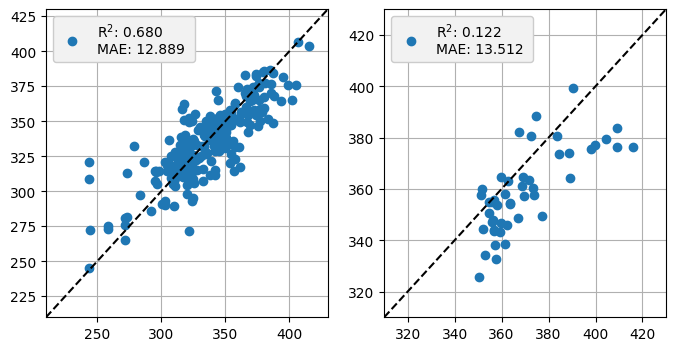

In [13]:
f, axs = plt.subplots(1,2,figsize=(8,4))
plot_scatter(axs[0], x1 + 273.15,  y1 + 273.15, xrange = [210, 430], fmts=['{:5.3f}','{:5.3f}'], metrics=['R2','MAE'])
plot_scatter(axs[1], x2 + 273.15,  y2 + 273.15, xrange = [310, 430], fmts=['{:5.3f}','{:5.3f}'], metrics=['R2','MAE'])
#f.savefig('./figs/output.xgb.test.pdf')

### SVR

In [20]:
outputs_svr = {}
for ftyp, (feat, test_feat) in features.items():
    output = {}
    for i in range(5):
        m_best = -50
        train_idx, valid_idx = cv[i]
        x_train = feat[train_idx]
        x_valid = feat[valid_idx]
        y_train = train_tgt[train_idx]
        y_valid = train_tgt[valid_idx]
        for kernel in ['linear']:
            bo = BayesianOptimization(svr_obj_fnc1, pbounds={'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=140)
        for kernel in ['sigmoid','poly']:
            bo = BayesianOptimization(svr_obj_fnc2, pbounds={'coef':[0,10], 'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=140)
        print('Fold: {} : {:10s} | {:10s} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f}'.format(i, ftyp, best['params']['kernel'], *best['measure']))
        output[i] = best.copy()
    outputs_svr[ftyp] = output

with open('../outputs/results/svr.gg.output.231212.pkl','wb') as f:
    pickle.dump(outputs_svr, f)

Fold: 0 : graph      | poly       |   0.368 /  17.762 |   0.454 /  17.586 |  -1.040 /  18.684
Fold: 1 : graph      | poly       |   0.412 /  17.484 |   0.400 /  18.504 |  -0.863 /  18.146
Fold: 2 : graph      | poly       |   0.392 /  18.590 |   0.354 /  16.576 |  -1.136 /  19.591
Data point [1.e+02 1.e+01 1.e-03] is not unique. 1 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 2 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 3 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 4 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 5 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 6 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 7 duplicates registered. Continuing ...
Data point [1.e+02 1.e+01 1.e-03] is not unique. 8 duplicates registered. Continuing ...
Data p

In [16]:
with open('../outputs/results/svr.gg.output.231212.pkl','rb') as f:
    outputs_svr = pickle.load(f)
    
for key, output in outputs_svr.items():
    for i, out in output.items():
        print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(out['measure'])))
    print('-'*80)
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).mean(0)))
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).std(0)))
    print('-'*80)

    x1 = np.hstack([v['valid'][0].reshape(-1) for v in output.values()])
    y1 = np.hstack([v['valid'][1].reshape(-1) for v in output.values()])
    x2 = output[0]['test'][0].reshape(-1)
    y2 = np.mean([v['test'][1].reshape(-1) for v in output.values()], 0)
    print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()

  0.368   17.762 /   0.454  17.586 /  -1.040  18.684
  0.412   17.484 /   0.400  18.504 /  -0.863  18.146
  0.392   18.590 /   0.354  16.576 /  -1.136  19.591
  0.405   16.845 /   0.395  21.019 /  -0.954  18.723
  0.419   18.141 /   0.234  17.402 /  -1.119  19.210
--------------------------------------------------------------------------------
  0.399   17.764 /   0.367  18.218 /  -1.022  18.871
  0.018    0.591 /   0.074   1.529 /   0.103   0.493
--------------------------------------------------------------------------------
                 /   0.392  18.218 /  -1.014  18.797

  0.805    8.377 /   0.478  15.503 /  -0.017  13.253
  0.807    8.580 /   0.659  12.531 /  -0.019  13.144
  0.751   10.536 /   0.506  15.654 /   0.325  11.120
  0.815    8.669 /   0.728  12.121 /   0.149  12.287
  0.799   10.227 /   0.677  11.087 /   0.076  13.169
--------------------------------------------------------------------------------
  0.795    9.278 /   0.610  13.379 /   0.103  12.595
  0.023    0.9

## RDKit fingreprints

### Data load

In [37]:
df_train = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.train.csv')
df_test = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_230823.tg.test.csv')
cv = CrossValidation(n_fold=5, n_data=df_train.shape[0], return_index=True)

In [38]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

col_sm = [f'SMILES_{x}' for x in 'ABCDE']
col_fr = [f'FR_{x}' for x in 'ABCDE']

all_smiles = np.unique(np.vstack([df_train[col_sm], df_test[col_sm]]).reshape(-1))
fps = {}
for s in all_smiles:
    fps[s] = {}
    m = Chem.MolFromSmiles(s)
    arr = np.zeros((0,), dtype=np.int8)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=256)
    fp2 = AllChem.GetHashedAtomPairFingerprintAsBitVect(m, nBits=256)
    fp3 = AllChem.GetMACCSKeysFingerprint(m)
    for name, fp in zip(['morgan','pair','maccs'], [fp1, fp2, fp3]):
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps[s][name] = arr.astype(float).copy()
        
def get_data(df, fptype='morgan'):
    global col_sm, col_fr, fps
    feats = []
    for i, row in df.iterrows():
        feat_fr = []
        feat_orig = []
        w = row[col_fr].sum()
        for smiles, fr in zip(row[col_sm], row[col_fr]):
            if fr == 0: continue
            fp = fps[smiles][fptype].copy()
            feat_orig.append(fp)
            feat_fr.append(fp.astype(float) * fr/w)
        feats.append(np.hstack([np.sum(feat_orig, 0), np.sum(feat_fr, 0)]))
    return np.array(feats), df.TG.values.reshape(-1,1)

### XGBoost

In [39]:
outputs_xgb = {}
for fp_type in ['morgan','pair','maccs']:
    output = {}
    train_feat, train_tgt = get_data(df_train, fptype=fp_type)
    test_feat, test_tgt = get_data(df_test, fptype=fp_type)
    for i in range(5):
        train_idx, valid_idx = cv[i]
        train_data = xgb.DMatrix(train_feat[train_idx], train_tgt[train_idx])
        valid_data = xgb.DMatrix(train_feat[valid_idx], train_tgt[valid_idx])
        test_data = xgb.DMatrix(test_feat, test_tgt)
        m_best = -1e5
        bo = BayesianOptimization(xgb_obj_fnc, pbounds={'eta':[1e-2,1], 'max_depth':[1,20]},
                                  random_state=100, verbose=0)
        bo.maximize(init_points=10, n_iter=290)
        tt, tp = best['train']
        vt, vp = best['valid']
        ft, fp = best['test']
        vals = [
            r2_score(tt, tp), np.sqrt(mean_squared_error(tt, tp)), mean_absolute_error(tt, tp),
            r2_score(vt, vp), np.sqrt(mean_squared_error(vt, vp)), mean_absolute_error(vt, vp),
            r2_score(ft, fp), np.sqrt(mean_squared_error(ft, fp)), mean_absolute_error(ft, fp)
        ]
        print('Fold: {} : {:10s} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(i, fp_type, *vals))
        output[i] = best.copy()
    outputs_xgb[fp_type] = output
#    print('-'*70)
#    print('AVG:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.mean(vals, axis=0)))
#    print('STD:     : {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | {:7.3f} / {:5.2f} / {:5.2f} | '.format(*np.std(vals, axis=0)))
with open('../outputs/results/xgb.fp.output.231211.pkl','wb') as f:
    pickle.dump(outputs_xgb, f)

Fold: 0 : morgan     |   0.969 /  5.47 /  3.95 |   0.597 / 18.16 / 12.05 |   0.108 / 16.33 / 12.53 | 
Fold: 1 : morgan     |   0.999 /  0.92 /  0.62 |   0.795 / 13.78 / 10.41 |   0.239 / 15.09 / 12.56 | 
Fold: 2 : morgan     |   1.000 /  0.41 /  0.24 |   0.791 / 14.06 / 10.60 |   0.151 / 15.93 / 12.75 | 
Fold: 3 : morgan     |   0.996 /  1.81 /  1.29 |   0.806 / 13.87 / 10.38 |  -0.046 / 17.68 / 14.34 | 
Fold: 4 : morgan     |   0.998 /  1.19 /  0.85 |   0.765 / 15.28 /  9.75 |  -0.037 / 17.61 / 12.83 | 
Fold: 0 : pair       |   1.000 /  0.03 /  0.02 |   0.582 / 18.50 / 12.85 |  -0.920 / 23.96 / 17.26 | 
Fold: 1 : pair       |   1.000 /  0.67 /  0.33 |   0.755 / 15.04 / 11.99 |   0.011 / 17.20 / 12.98 | 
Fold: 2 : pair       |   1.000 /  0.09 /  0.05 |   0.734 / 15.85 / 12.53 |  -0.221 / 19.11 / 15.43 | 
Fold: 3 : pair       |   1.000 /  0.52 /  0.30 |   0.812 / 13.68 /  8.90 |  -0.052 / 17.74 / 13.00 | 
Fold: 4 : pair       |   1.000 /  0.01 /  0.01 |   0.717 / 16.74 / 11.00 |  -0.186

In [20]:
with open('../outputs/results/xgb.fp.output.231211.pkl','rb') as f:
    outputs_xgb = pickle.load(f)
    
for key, output in outputs_xgb.items():
    for i, out in output.items():
        print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(out['measure'])))
    print('-'*80)
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).mean(0)))
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).std(0)))
    print('-'*80)

    x1 = np.hstack([v['valid'][0].reshape(-1) for v in output.values()])
    y1 = np.hstack([v['valid'][1].reshape(-1) for v in output.values()])
    x2 = output[0]['test'][0].reshape(-1)
    y2 = np.mean([v['test'][1].reshape(-1) for v in output.values()], 0)
    print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()    

  0.969    3.954 /   0.597  12.054 /   0.108  12.525
  0.999    0.618 /   0.795  10.409 /   0.239  12.556
  1.000    0.242 /   0.791  10.596 /   0.151  12.754
  0.996    1.294 /   0.806  10.379 /  -0.046  14.339
  0.998    0.847 /   0.765   9.754 /  -0.037  12.829
--------------------------------------------------------------------------------
  0.993    1.391 /   0.751  10.639 /   0.083  13.001
  0.012    1.326 /   0.078   0.762 /   0.110   0.679
--------------------------------------------------------------------------------
                 /   0.759  10.639 /   0.206  12.425

  1.000    0.021 /   0.582  12.852 /  -0.920  17.259
  1.000    0.331 /   0.755  11.989 /   0.011  12.977
  1.000    0.053 /   0.734  12.526 /  -0.221  15.427
  1.000    0.298 /   0.812   8.903 /  -0.052  12.999
  1.000    0.006 /   0.717  11.002 /  -0.186  13.219
--------------------------------------------------------------------------------
  1.000    0.142 /   0.720  11.454 /  -0.273  14.376
  0.000    0.1

### SVR

In [19]:
outputs_svr = {}
for fp_type in ['morgan','pair','maccs']:
    output = {}
    train_feat, train_tgt = get_data(df_train, fptype=fp_type)
    test_feat, test_tgt = get_data(df_test, fptype=fp_type)
    for i in range(5):
        m_best = -50
        train_idx, valid_idx = cv[i]
        x_train = train_feat[train_idx]
        x_valid = train_feat[valid_idx]
        y_train = train_tgt[train_idx]
        y_valid = train_tgt[valid_idx]
        for kernel in ['linear']:
            bo = BayesianOptimization(svr_obj_fnc1, pbounds={'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=140)
        for kernel in ['sigmoid','poly']:
            bo = BayesianOptimization(svr_obj_fnc2, pbounds={'coef':[0,10], 'c':[0.1,100], 'eps':[1e-3,10]},
                                      random_state=100, verbose=0, allow_duplicate_points=True)
            bo.maximize(init_points=10, n_iter=140)
        print('Fold: {} : {:10s} | {:10s} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f} | {:7.3f} / {:7.3f}'.format(i, fp_type, best['params']['kernel'], *best['measure']))
        output[i] = best.copy()
    outputs_svr[fp_type] = output

with open('../outputs/results/svr.fp.output.231212.pkl','wb') as f:
    pickle.dump(outputs_svr, f)

Fold: 0 : morgan     | poly       |   0.901 /   3.656 |   0.756 /  10.198 |   0.467 /   9.864
Fold: 1 : morgan     | poly       |   0.917 /   4.056 |   0.799 /   9.801 |   0.449 /   9.850
Fold: 2 : morgan     | poly       |   0.911 /   3.913 |   0.721 /  11.218 |   0.283 /  11.063
Fold: 3 : morgan     | poly       |   0.908 /   4.066 |   0.730 /  12.164 |   0.495 /   9.181
Fold: 4 : morgan     | poly       |   0.893 /   4.157 |   0.753 /   9.421 |   0.353 /  10.974
Fold: 0 : pair       | poly       |   0.936 /   2.584 |   0.682 /  12.281 |   0.515 /   9.588
Fold: 1 : pair       | poly       |   0.923 /   2.718 |   0.812 /   9.938 |   0.591 /   8.402
Fold: 2 : pair       | poly       |   0.915 /   3.795 |   0.584 /  12.184 |   0.046 /  11.730
Fold: 3 : pair       | poly       |   0.932 /   2.890 |   0.753 /  12.089 |   0.492 /   9.151
Fold: 4 : pair       | poly       |   0.934 /   2.618 |   0.710 /  10.413 |   0.287 /  10.877
Fold: 0 : maccs      | poly       |   0.863 /   7.865 |   0.

In [18]:
with open('../outputs/results/svr.fp.output.231212.pkl','rb') as f:
    outputs_svr = pickle.load(f)
    
for key, output in outputs_svr.items():
    for i, out in output.items():
        print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array(out['measure'])))
    print('-'*80)
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).mean(0)))
    print('{:7.3f}  {:7.3f} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format(*np.array([v['measure'] for v in output.values()]).std(0)))
    print('-'*80)

    x1 = np.hstack([v['valid'][0].reshape(-1) for v in output.values()])
    y1 = np.hstack([v['valid'][1].reshape(-1) for v in output.values()])
    x2 = output[0]['test'][0].reshape(-1)
    y2 = np.mean([v['test'][1].reshape(-1) for v in output.values()], 0)
    print('{:7s}  {:7s} / {:7.3f} {:7.3f} / {:7.3f} {:7.3f}'.format('','',r2_score(x1, y1), mean_absolute_error(x1, y1), r2_score(x2, y2), mean_absolute_error(x2,y2)))
    print()

  0.901    3.656 /   0.756  10.198 /   0.467   9.864
  0.917    4.056 /   0.799   9.801 /   0.449   9.850
  0.911    3.913 /   0.721  11.218 /   0.283  11.063
  0.908    4.066 /   0.730  12.164 /   0.495   9.181
  0.893    4.157 /   0.753   9.421 /   0.353  10.974
--------------------------------------------------------------------------------
  0.906    3.970 /   0.752  10.560 /   0.409  10.186
  0.008    0.175 /   0.027   1.001 /   0.079   0.723
--------------------------------------------------------------------------------
                 /   0.758  10.560 /   0.490   9.527

  0.936    2.584 /   0.682  12.281 /   0.515   9.588
  0.923    2.718 /   0.812   9.938 /   0.591   8.402
  0.915    3.795 /   0.584  12.184 /   0.046  11.730
  0.932    2.890 /   0.753  12.089 /   0.492   9.151
  0.934    2.618 /   0.710  10.413 /   0.287  10.877
--------------------------------------------------------------------------------
  0.928    2.921 /   0.708  11.381 /   0.386   9.950
  0.008    0.4